<a href="https://colab.research.google.com/github/Skalwalker/AntiMoneyLaundering/blob/main/anti_money_laundering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Transactions for Anti Money Laundering

The project is based on the analysis of the «IBM Transactions for Anti Money Laundering» dataset published on [Kaggle](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml) and released under the Community Data License Agreement – Sharing – Version 1.0. This dataset contains several CSV files, each having a different combination of data size and amount of illicit transactions.

## About

This project is a partial requisite for completing the courses of "Algorithms for massive datasets" and "Statistical methods for ML" on the masters degree computer science program from Università degli Studi di Milano.

- **Author:** Renato Avellar Nobre
- **Matriculation Number:** 984405
- **Exam Project Year:** 22/23

### Disclaimer

"I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study."


# [ALDER](https://github.com/Skalwalker/AntiMoneyLaundering): **A**nti Money **L**aundering using **DE**cision T**R**ees

This project proposes and explores ALDER, an implementation of decision trees and random forest algorithms to detect money laundering. It is designed to classify laundering transactions and can process large-scale data in a simulated distributed environment. ALDER utilizes the IBM Transactions for Anti Money Laundering (IBM TAML) dataset and leverages Apache Spark for scalable computing. It can either use a single decision tree or distribute the computation of multiple decision trees to create a scalable random forest predictor. Therefore, ALDER aims to address research questions related to its effectiveness in classifying money laundering, its performance with different dataset sizes, and its scalability in real distributed environments.

Over many contributions, ALDER applies a rigorous data engineering pipeline with a strong exploratory data analysis. Such combinations allowed ALDER to create robust features able to generalize the content of the data without creating data leakages to potential overfitting. Additionally, ALDER does not rely on external libraries for its decision tree nor its random forest, designing a decision tree from scratch with mechanisms to work with data imbalance, big data thresholds and multiple information gain functions. Finally, ALDER applies a state-of-the-art hyperparameter tuning with Bayesian optimization and the Hyperopt library.

![](https://raw.githubusercontent.com/Skalwalker/AntiMoneyLaundering/main/images/overview.png)


## Before we start...

Please upload the JSON file of your Kaggle API by executing the code below. Kaggle API JSON files can be generated on your [Kaggle user profile setting](https://www.kaggle.com/settings)

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


**Also, choose whether to run or skip the Exploratory Data Analysis Process and Feature Vizualisation.**

*   **Processing** may take a while
*   **Skipping** will remove previous outputs



In [2]:
skip_eda = True # About 15 minutes to run
skip_feature_viz = True # About 30 minutes to run
skip_medium_experiments = True # Over 3 hours to run

# Setup

In [3]:
import os

data_folders = ["01_raw"]

try:
    # Create data directory
    os.makedirs("data", exist_ok = True)
    # Create sub data folders
    [os.makedirs("data/" + folder_name, exist_ok = True) for folder_name in data_folders]
    print("Directories created successfully")
except OSError as error:
    print(f"Directories can not be created: {error}")


Directories created successfully


## Fetching Files from Kaggle

ALDER starts by downloading the IBM TAML dataset from the Kaggle website. Among multiple files available in the dataset, ALDER selects a subset for its methodology. The original dataset files are in CSV format and large enough to have memory issues while loading them in primary memory. Therefore, to be able to process all the selected data and further parallelize the distribution of decision trees in the random forest, ALDER relies on PySpark.

In [4]:
!pip install kaggle
!kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml

100% 7.42G/7.42G [01:47<00:00, 139MB/s]
100% 7.42G/7.42G [01:47<00:00, 74.0MB/s]


In [5]:
!unzip ibm-transactions-for-anti-money-laundering-aml.zip -d ./data/01_raw/ -x "LI*" "HI-Large*"
!rm ibm-transactions-for-anti-money-laundering-aml.zip
!rm ./data/01_raw/*.txt

Archive:  ibm-transactions-for-anti-money-laundering-aml.zip
  inflating: ./data/01_raw/HI-Medium_Patterns.txt  
  inflating: ./data/01_raw/HI-Medium_Trans.csv  
  inflating: ./data/01_raw/HI-Small_Patterns.txt  
  inflating: ./data/01_raw/HI-Small_Trans.csv  


## Installations and Imports

In [6]:
!pip install --upgrade ipykernel
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.24.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=fd21ffda6158918a48647b66be8bd234bfbdbce261996a9a7882d97318aa4f83
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully 

In [7]:
import gc
import random

import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler, FeatureHasher
from pyspark.sql.functions import (col, sum, lag, round, lit, to_timestamp, countDistinct, hour,
                                   dayofmonth, dayofmonth, minute, date_format, to_date, when,
                                   count, row_number, coalesce, unix_timestamp, max)


from IPython.core.magic import register_line_cell_magic

# Create a special ipython magic to skip cells
@register_line_cell_magic
def skip(line, cell=None):

    if eval(line):
        return

    get_ipython().ex(cell)

## Setting Up PySpark

We initialize and configure a spark session before opening and preprocessing the data files. The following list is a selected subset of the spark configurations used in ALDER's code to initialize the spark session considering the available environment capabilities. Especially the values are optimized to load a 4GB dataset on the considered colab environment with a 2-core CPU and 12GB primary memory.


*  **Driver Memory (3GB):** This property specifies the amount of memory allocated for the Spark driver, which is responsible for coordinating the Spark application.  
*  **Executor Instances (2):**  With a 2-core CPU, we can have a maximum of two executor instances. Setting this property to 2 will utilize both cores for parallel processing.
* **Executor Memory (4GB):** This property sets the amount of memory allocated for each executor. Since we have roughly 12GB available in the Colab and 3 GB are set for the driver, each executor will have 4GB available, leaving 1GB for free as a margin.
* **Executor Cores (1):** This property determines the number of CPU cores assigned to each worker. It is generally recommended to set this value to the number of available CPU cores on the machine. We assign one core peer worker since we only have two cores and two workers.
* **Shuffle Partitions (2):** This property sets the number of partitions to be used for shuffling data during Spark SQL operations, which is a costly operation in terms of memory and CPU usage. Since we have limited resources, we keep the number of shuffle partitions low.


In [8]:
if 'spark' in vars():
  spark.stop()

# Count available cores
cores = multiprocessing.cpu_count()
# In this case the amount of executors will be equal to the amount of cores
instances = cores

spark = SparkSession.builder \
          .appName("MoneyLaundering") \
          .config("spark.driver.memory", "3g") \
          .config("spark.executor.memory", "4g") \
          .config("spark.executor.instances", cores) \
          .config("spark.executor.cores", cores//instances) \
          .config("spark.sql.shuffle.partitions", cores) \
          .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
          .config("spark.sql.execution.arrow.enabled", "true") \
          .getOrCreate()

spark.sparkContext.setLogLevel("OFF")

# Print spark properties
for x in spark.sparkContext.getConf().getAll():
  print(f"{x[0].replace('.', ' ').capitalize()}: {x[1]}")

Spark app submittime: 1688748400985
Spark sql execution arrow enabled: true
Spark executor memory: 4g
Spark app name: MoneyLaundering
Spark executor id: driver
Spark sql shuffle partitions: 2
Spark driver extrajavaoptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.

# Data Engineering Preparation

Figure bellow shows an overview of the data engineering pipeline, from reading the considered files to splitting and saving the final formats. For this specific pipeline, we consider abstract representations of the cookie-cutter data layers for data engineering, which means that we are following only the cookie-cutter logical reasoning of data organization rather than persisting the data for each layer.

<img src="https://raw.githubusercontent.com/Skalwalker/AntiMoneyLaundering/main/images/datapipeline.png" alt="" width="300"/>



In [9]:
!ls -l --block-size=GB ./data/01_raw/

total 4GB
-rw-r--r-- 1 root root 4GB Feb 28 12:08 HI-Medium_Trans.csv
-rw-r--r-- 1 root root 1GB Feb 28 12:12 HI-Small_Trans.csv


## Raw Data

First, we start with the Raw Data Layer. The raw layer is the starting point of the data pipeline and includes the sourced data that should never be altered. It serves as the single source of truth for all subsequent work. Typically, these data models are untyped, such as CSV files. We are considering two CSV data files, small and large. Those CSVs will not be altered and will remain in the disk as our source of truth. We start the pipeline in the raw layer by verifying the columns, checking if they are the same for both datasets and checking for null values. Since the data does not contain null values and the columns are the same, we start the processing in the intermediate layer by fixing its schema.


In [10]:
# High Ilicity Datasets
hi_small_df = spark.read.csv("./data/01_raw/HI-Small_Trans.csv", header=True)
hi_medium_df = spark.read.csv("./data/01_raw/HI-Medium_Trans.csv", header=True)
# Print Columns
hi_small_df.columns

['Timestamp',
 'From Bank',
 'Account2',
 'To Bank',
 'Account4',
 'Amount Received',
 'Receiving Currency',
 'Amount Paid',
 'Payment Currency',
 'Payment Format',
 'Is Laundering']

In [11]:
# Print data schema
hi_small_df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)



In [12]:
# Verify if all columns are equal
hi_cols_equal = (hi_small_df.columns == hi_medium_df.columns)
print(f"Are all Small and Medium Dataset cols the same? {hi_cols_equal}")

Are all Small and Medium Dataset cols the same? True


In [13]:
# Print a small part of the dataset
hi_small_df.show()

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:20|      010|8000EBD30|    010|8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:20|    03208|8000F4580|    001|8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|
|2022/09/01 00:00|    03209|8000F4670|  03209|8000F4670|       14675.57|         US Dollar|   14675.57|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:02|      012|8000F5030|    012|8000F5030|        2806.97|         US Dollar|    2806.

In [14]:
# Count the nulls for each column in the dataset
null_counts = hi_small_df.select([sum(col(column).isNull().cast("integer")).alias(column) for column in hi_small_df.columns])
null_counts.show()

+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|        0|        0|       0|      0|       0|              0|                 0|          0|               0|             0|            0|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+



## Intermediate Data

In practice, the Intermediate Data Layer only needs to be a "typed mirror" of the raw layer within the source data model. Once the intermediate layer exists, we never have to touch the raw layer, and we eliminate the risks associated with mutating the original data. Cleaning column names, parsing dates and dropping completely null columns are other transformations commonly performed at this stage. Also, profiling, an Exploratory Data Analysis (EDA) and any data quality assessments should be performed at this point. In the data pipeline figure, the first and second steps reside in the intermediate layer. The first transformation we do with our data is to apply a proper schema to the dataframe, thus creating the "typed mirror" of our data. Following we fix the timestamp column to process it as a proper timestamp data format.

In [15]:
# Create proper schema for the dataset
schema = StructType([
    StructField("Timestamp", StringType(), nullable=False),
    StructField("From Bank", IntegerType(), nullable=False),
    StructField("Account2", StringType(), nullable=False),
    StructField("To Bank", IntegerType(), nullable=False),
    StructField("Account4", StringType(), nullable=False),
    StructField("Amount Received", FloatType(), nullable=False),
    StructField("Receiving Currency", StringType(), nullable=False),
    StructField("Amount Paid", FloatType(), nullable=False),
    StructField("Payment Currency", StringType(), nullable=False),
    StructField("Payment Format", StringType(), nullable=False),
    StructField("Is Laundering", IntegerType(), nullable=False),
])

In [16]:
# Load the data with the created schema
hi_small_df = spark.read.csv("./data/01_raw/HI-Small_Trans.csv", header=True, schema=schema)
hi_medium_df = spark.read.csv("./data/01_raw/HI-Medium_Trans.csv", header=True, schema=schema)

# Fixing Timestamp
def fix_timestamp(df):
  format = "yyyy/MM/dd HH:mm"
  df = df.withColumn("Timestamp2",to_timestamp("Timestamp", format=format).cast('timestamp'))
  df = df.drop("Timestamp")
  df = df.withColumnRenamed("Timestamp2", "Timestamp")
  return df

hi_small_df = fix_timestamp(hi_small_df)
hi_medium_df = fix_timestamp(hi_medium_df)
hi_small_df.printSchema()

root
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: float (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: float (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)



In [17]:
# Show the typed dataset
hi_small_df.show(5)

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|       10|8000EBD30|     10|8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|2022-09-01 00:20:00|
|     3208|8000F4580|      1|8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|2022-09-01 00:20:00|
|     3209|8000F4670|   3209|8000F4670|       14675.57|         US Dollar|   14675.57|       US Dollar|  Reinvestment|            0|2022-09-01 00:00:00|
|       12|8000F5030|     12|8000F5030|        2806.97|         US Dollar|    2806

### Exploratory Data Analysis
---

With the data properly typed, we can now perform an EDA to generate insights on the data format and thus make informed decisions on our feature engineering process. We analyzed only the small dataset for simplicity and time-saving and extrapolated its insights to the medium. The first step of the EDA process was to split the dataset into legit and laundering transactions to analyze the features in each case. Visualizing the "Amount Received" and "Amount Paid" features, we noticed that the statistics do not change significantly between one another, realizing that the only change between those values is when the payment and receive are made from different currencies. We also analyzed that most of the laundering occurs with the "ACH" payment format and that there is no laundering in "Reinvestment". Further investigation also showed that laundering is rarely made in a transaction where the origin and destination accounts are the same and never in transactions with different currencies. This comprehensive analysis also showed that numerous accounts are linked with fraudulent transactions and can happen over multiple currencies.


In [18]:
%%skip $skip_eda
# Create a small_df version to not make changes on the small df
small_df = hi_small_df

In [19]:
%%skip $skip_eda
# Get the label distribution in the dataset
small_df.groupBy("Is Laundering").count().show()

+-------------+-------+
|Is Laundering|  count|
+-------------+-------+
|            0|5073168|
|            1|   5177|
+-------------+-------+



In [20]:
%%skip $skip_eda
# Split the dataset into Legit and Laundering Transactions to analyze the feature in each case
small_laundering_df = small_df.filter(small_df["Is Laundering"] == 1)
small_legit_df = small_df.filter(small_df["Is Laundering"] == 0)

# Show the descriptions of amount received and paid
float_columns = ["Amount Received", "Amount Paid"]
small_laundering_df.select(float_columns).describe().show()
small_legit_df.select(float_columns).describe().show()

+-------+--------------------+--------------------+
|summary|     Amount Received|         Amount Paid|
+-------+--------------------+--------------------+
|  count|                5177|                5177|
|   mean| 3.613531071586281E7| 3.613531071586281E7|
| stddev|1.5279186868932502E9|1.5279186868932502E9|
|    min|            0.003227|            0.003227|
|    max|        8.4853146E10|        8.4853146E10|
+-------+--------------------+--------------------+

+-------+--------------------+-------------------+
|summary|     Amount Received|        Amount Paid|
+-------+--------------------+-------------------+
|  count|             5073168|            5073168|
|   mean|   5957962.500255194|  4477000.057857775|
| stddev|1.0365634624133482E9|8.688463078849382E8|
|    min|              1.0E-6|             1.0E-6|
|    max|       1.04630236E12|      1.04630236E12|
+-------+--------------------+-------------------+



In [21]:
%%skip $skip_eda
# Analysis of Ilegality through payment formats
small_laundering_df.groupBy("Payment Format").count().show()
small_legit_df.groupBy("Payment Format").count().show()

+--------------+-----+
|Payment Format|count|
+--------------+-----+
|           ACH| 4483|
|       Bitcoin|   56|
|        Cheque|  324|
|   Credit Card|  206|
|          Cash|  108|
+--------------+-----+

+--------------+-------+
|Payment Format|  count|
+--------------+-------+
|           ACH| 596314|
|       Bitcoin| 146035|
|  Reinvestment| 481056|
|        Cheque|1864007|
|   Credit Card|1323118|
|          Cash| 490783|
|          Wire| 171855|
+--------------+-------+



In [22]:
%%skip $skip_eda
# Show ilegal transactions are made for the same account
small_laundering_df.filter(small_laundering_df["Account2"] == small_laundering_df["Account4"]).show()

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|    48309|811C599A0|  48309|811C599A0|       48649.42|       Saudi Riyal|   48649.42|     Saudi Riyal|           ACH|            1|2022-09-04 05:03:00|
|    15231|80266F880|  15231|80266F880|       14998.24|              Euro|   14998.24|            Euro|           ACH|            1|2022-09-01 14:04:00|
|    15231|80266F880|  15231|80266F880|        4895.52|              Euro|    4895.52|            Euro|           ACH|            1|2022-09-03 19:55:00|
|   150240|812D22980| 150240|812D22980|       71726.48|       Saudi Riyal|   71726

In [23]:
%%skip $skip_eda
# Show ilegal transactions difference in payment ammount
small_laundering_df.filter(small_laundering_df["Amount Paid"] != small_laundering_df["Amount Received"]).show()

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [24]:
%%skip $skip_eda
# Show ilegal transactions in different currencies
small_laundering_df.filter(small_laundering_df["Receiving Currency"] != small_laundering_df["Payment Currency"]).show()

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [25]:
%%skip $skip_eda
# Show ilegal transactions distributions in different currencies
small_laundering_df.groupBy("Receiving Currency").count().show()
small_laundering_df.groupBy("Payment Currency").count().show()

+------------------+-----+
|Receiving Currency|count|
+------------------+-----+
|         US Dollar| 1912|
|              Euro| 1372|
|              Yuan|  184|
|               Yen|  155|
|       Swiss Franc|  193|
|             Rupee|  167|
| Australian Dollar|  127|
|       Saudi Riyal|  374|
|      Mexican Peso|   92|
|          UK Pound|  132|
|       Brazil Real|   57|
|           Bitcoin|   56|
|   Canadian Dollar|  128|
|            Shekel|   95|
|             Ruble|  133|
+------------------+-----+

+-----------------+-----+
| Payment Currency|count|
+-----------------+-----+
|        US Dollar| 1912|
|             Euro| 1372|
|             Yuan|  184|
|              Yen|  155|
|      Swiss Franc|  193|
|            Rupee|  167|
|Australian Dollar|  127|
|      Saudi Riyal|  374|
|     Mexican Peso|   92|
|         UK Pound|  132|
|      Brazil Real|   57|
|          Bitcoin|   56|
|  Canadian Dollar|  128|
|           Shekel|   95|
|            Ruble|  133|
+-----------------

**Account-related analysis:**

Following the EDA, we deeply studied how accounts were related to money laundering. Unusually high transaction activity or many accounts linked to a particular entity may indicate suspicious behaviour. From the analysis insights, we devised that it could be useful to create features that capture the frequency and volume of transactions from both the "From Account" and "To Account". Most importantly, this analysis clarified that including the account identifiers as features would introduce data leakage because the model could learn to classify specific accounts instead of generalizing the account behaviour. Further, the destination bank and the behaviour of destination accounts appear to have strong predictive power.

In [26]:
%%skip $skip_eda
# Shows legit examples of an account that makes ilegal transactions
small_legit_df.where(small_laundering_df["Account2"] == "10042B6A8").show(10)

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [27]:
%%skip $skip_eda
# Shows ilegal examples of the same account
small_laundering_df.where(small_laundering_df["Account2"] == "10042B6A8").show(10)

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [28]:
%%skip $skip_eda
# Shows transactions made by the receiving account of the ilegal transactions
receinving_accs = ["806242CD0", "806573660", "80E95DAC0", "801F02820", "805F99460",
                   "80AEDE4A0", "80B2862D0", "816325220", "8041E5A30", "8007D19B0"]
small_laundering_df.where(small_laundering_df["Account2"].isin(receinving_accs)).show(10)

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



**Time-related analysis:**

 Finally, the last step of the EDA was to extract insights from the time correlation of the laundering transactions. At this point is worth noticing that ALDER is not a time series model. We processed the features so the predictor could work with daily batches of transactions and did not consider which transaction was made first. Insights from the time-related analysis showed a higher ratio of illicit transactions on Saturday and Sunday.

In [29]:
%%skip $skip_eda
# Get the amount of laundering and legit transactions in a specific weekday
weekly_laundering = small_laundering_df.withColumn("Weekday", date_format('Timestamp', 'EEEE')).groupBy("Weekday").count().cache()
weekly_legit = small_legit_df.withColumn("Weekday", date_format('Timestamp', 'EEEE')).groupBy("Weekday").count().cache()
# Show values with rate
weekly_laundering.join(weekly_legit.withColumnRenamed("count", "count2"), "Weekday"). \
                 withColumn("Laundering Rate", col("count") / col("count2")). \
                 withColumn("Laundering Rate", col("Laundering Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Laundering Rate").desc()). \
                 show()

+---------+-----+-------+---------------+
|  Weekday|count| count2|Laundering Rate|
+---------+-----+-------+---------------+
|   Sunday|  647| 207190|   0.0031227376|
| Saturday|  848| 414882|   0.0020439547|
|   Monday|  641| 482290|   0.0013290759|
|  Tuesday|  637| 481636|   0.0013225756|
|Wednesday|  567| 482305|   0.0011756046|
|   Friday|  948|1408014|   0.0006732888|
| Thursday|  889|1596851|   0.0005567207|
+---------+-----+-------+---------------+



In [30]:
%%skip $skip_eda
# Get the amount of laundering and legit transactions in a specific hour
hourly_laundering = small_laundering_df.withColumn("Hour", hour('Timestamp')).groupBy("Hour").count().cache()
hourly_legit = small_legit_df.withColumn("Hour", hour('Timestamp')).groupBy("Hour").count().cache()
# Show values with rate
hourly_laundering.join(hourly_legit.withColumnRenamed("count", "count2"), "Hour"). \
                 withColumn("Hourly Rate", col("count") / col("count2")). \
                 withColumn("Hourly Rate", col("Hourly Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Hourly Rate").desc()). \
                 show()

+----+-----+------+------------+
|Hour|count|count2| Hourly Rate|
+----+-----+------+------------+
|  12|  336|192636|0.0017442223|
|  16|  311|193096|0.0016105978|
|  11|  295|193205|0.0015268756|
|  13|  292|192229|0.0015190216|
|  14|  279|192508|0.0014492904|
|  15|  263|194608|0.0013514347|
|   8|  258|192663|0.0013391258|
|  17|  257|192897|0.0013323172|
|  18|  255|193066|0.0013207919|
|  10|  234|192995|0.0012124666|
|  19|  231|192593|0.0011994205|
|   9|  217|192735|0.0011258983|
|   6|  207|194249|0.0010656426|
|   7|  195|193141|0.0010096251|
|   5|  188|193712|0.0009705129|
|   2|  165|192978|0.0008550197|
|  21|  154|192038|0.0008019246|
|   4|  154|193012|0.0007978779|
|   1|  152|193576|0.0007852213|
|  23|  150|193195|0.0007764176|
+----+-----+------+------------+
only showing top 20 rows



In [31]:
%%skip $skip_eda
# Get the amount of laundering and legit transactions in a specific day of the month
daily_laundering = small_laundering_df.withColumn("Date", dayofmonth('Timestamp')).groupBy("Date").count().cache()
daily_legit = small_legit_df.withColumn("Date", dayofmonth('Timestamp')).groupBy("Date").count().cache()
# Show values with rate
daily_laundering.join(daily_legit.withColumnRenamed("count", "count2"), "Date"). \
                 withColumn("Daily Rate", col("count") / col("count2")). \
                 withColumn("Daily Rate", col("Daily Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Daily Rate").desc()). \
                 show()

+----+-----+-------+------------+
|Date|count| count2|  Daily Rate|
+----+-----+-------+------------+
|  18|    8|      3|2.6666666667|
|  17|   15|      8|1.8750000000|
|  15|   28|     18|1.5555555556|
|  12|  170|    111|1.5315315315|
|  11|  232|    164|1.4146341463|
|  14|   70|     51|1.3725490196|
|  13|  106|     78|1.3589743590|
|  16|   26|     20|1.3000000000|
|  10|  442| 207883|0.0021261960|
|   4|  407| 207023|0.0019659651|
|   3|  391| 206991|0.0018889710|
|   8|  539| 482234|0.0011177146|
|   6|  531| 481558|0.0011026709|
|   7|  497| 482254|0.0010305772|
|   5|  471| 482179|0.0009768157|
|   9|  514| 653953|0.0007859892|
|   2|  408| 754041|0.0005410846|
|   1|  322|1114599|0.0002888931|
+----+-----+-------+------------+



## Feature Data


The insights from the EDA allow the processing and creation of the Feature Data Layer. The feature layer comprises a data model with a collection of features defined based on the primary data. In practical terms, this layer represents the independent variables, engineered features and the target variable, which will serve as the foundation for applying machine learning models. Additionally, any data cleaning and new features are removed at this step. We start creating the time-related features: Hour of the Day, Day of the Month, and Weekday (we also create intermediary features Minute and Date to assist further feature creation). Next, we create a self-payment Boolean feature indicating if the transaction's origin and final account are the same, and we clean the payment format to remove all the "Reinvestment" transactions. Further, we create a Boolean currency feature indicating if the transaction's origin and final currencies are the same, thus being able to drop the Payment Currency and keep only the Receiving for the model. We do a similar process for the amount features by creating a feature of received ratio and removing the amount paid feature.

At this point, we are starting the second node of the second column of the data pipeline feature and considering that we will be removing the account features from the final data, we needed to find ways of extracting the relationship of the transactions with the accounts. Therefore we create the following features related to each account: total transaction amount in hour/day, the number of the transaction in the hour/day, and the time since the last transaction. Similarly, we also create features to establish the relationship between the origin and destination account: total transaction to the same account in hour/day, number of the transaction to this account in the hour/day, time in minutes since the last transaction to this account, amount of transactions where the receiving account has been involved in the last hour/day.

The final step at the data feature layer is cleaning the unwanted features; therefore, we drop the Timestamp, the Origin and the Destination Account.

In [32]:
def create_time_features(ds):
  # Create feature - hour of transaction
  ds = ds.withColumn("Hour", hour('Timestamp'))
  # Create feature - day of transaction
  ds = ds.withColumn("Day", dayofmonth('Timestamp'))
  # Create feature - minute of transaction
  ds = ds.withColumn("Minute", minute('Timestamp'))
  # Create feature - date of transaction
  ds = ds.withColumn("Date", to_date('Timestamp'))
  # Create feature - weekday of transaction
  ds = ds.withColumn("Weekday", date_format('Timestamp', 'EEEE'))
  return ds

def create_self_payment_feature(ds):
  # Create feature self payment (origin and destination account is the same)
  ds = ds.withColumn("SelfPayment", when(col("Account2") == col("Account4"), 1).otherwise(0))
  return ds

def clean_payment_format(ds):
  # Return dataframe with Reinvestment rows filtered out
  ds = ds.where(col("Payment Format") != "Reinvestment")
  return ds

def create_currency_features(ds):
  # Create feature - transaction made in the same currency or not
  ds = ds.withColumn("SameCurrencyTransaction", when(col("Receiving Currency") == col("Payment Currency"), 1).otherwise(0))
  # Drop one of the currency features
  ds = ds.drop("Payment Currency")
  # Rename column
  ds = ds.withColumnRenamed("Receiving Currency", "Currency")
  return ds

def create_ammount_features(ds):
  # Create feature amount ratio of the transaction
  ds = ds.withColumn("AmtReceivedRatio",  col("Amount Received") / col("Amount Paid"))
  # Drop one of the features
  ds = ds.drop("Amount Paid")
  # Rename column
  ds = ds.withColumnRenamed("Amount Received", "AmtReceived")
  return ds

def trans_by_acc_features(ds):
  # Total Transaction Ammount in Hour
  temp = ds.groupBy("Account2", "Hour").agg(count("*").alias("AccTransAmtInHour"))
  ds = ds.join(temp, on=["Account2", "Hour"], how="left")

  # Total Transaction Ammount in Day
  temp = ds.groupBy("Account2", "Day").agg(count("*").alias("AccTransAmtInDay"))
  ds = ds.join(temp, on=["Account2", "Day"], how="left")

  # Transaction Number by the Account in the Hour
  w = Window.partitionBy(ds["Account2"], ds["Date"], ds["Hour"]).orderBy(ds["Minute"])
  ds = ds.withColumn('AccTransNumByHour', row_number().over(w))
  # Transaction Number by the Account in the Day
  w = Window.partitionBy(ds["Account2"], ds["Date"]).orderBy(ds["Hour"], ds["Minute"])
  ds = ds.withColumn('AccTransNumByDay', row_number().over(w))

  # Time in mins since last transaction
  w = Window.partitionBy(ds["Account2"]).orderBy(ds["Timestamp"])
  ds = ds.withColumn("MinsSinceLastTrans", coalesce(round((unix_timestamp("Timestamp") - lag(unix_timestamp("Timestamp"), 1).over(w))/60), lit(0)))

  return ds

def receiving_acc_features(ds):
  # Total Transaction Ammount to same account in Hour
  temp = ds.groupBy("Account2", "Account4", "Hour").agg(count("*").alias("HourAccTransAmtToSameAcc"))
  ds = ds.join(temp, on=["Account2", "Account4", "Hour"], how="left")

  # Total Transaction Ammount to same account in Day
  temp = ds.groupBy("Account2", "Account4", "Day").agg(count("*").alias("DayAccTransAmtToSameAcc"))
  ds = ds.join(temp, on=["Account2", "Account4", "Day"], how="left")

  # Transaction Number by the Account to same account in the Hour
  w = Window.partitionBy(ds["Account2"], ds["Account4"], ds["Date"], ds["Hour"]).orderBy(ds["Minute"])
  ds = ds.withColumn('HourAccTransNumToSameAcc', row_number().over(w))
  # Transaction Number by the Account to same account in the Day
  w = Window.partitionBy(ds["Account2"], ds["Account4"], ds["Date"]).orderBy(ds["Hour"], ds["Minute"])
  ds = ds.withColumn('DayAccTransNumToSameAcc', row_number().over(w))

  # Time in mins since last transaction to same account
  w = Window.partitionBy(ds["Account2"], ds["Account4"]).orderBy(ds["Timestamp"])
  ds = ds.withColumn("MinsSinceLastTransToSameAcc", coalesce(round((unix_timestamp("Timestamp") - lag(unix_timestamp("Timestamp"), 1).over(w))/60), lit(0)))

  # Amt of Transactions to Acc4 in Last Hour
  w = Window.partitionBy(ds['Account4'], ds["Date"], ds["Hour"]).orderBy('Minute')
  ds = ds.withColumn('HourDestAccTransReceived', count('Account2').over(w))

  # Amt of Transactions to Acc4 in Last Day
  w = Window.partitionBy(ds['Account4'], ds["Date"]).orderBy(ds["Hour"], ds["Minute"])
  ds = ds.withColumn('DayDestAccTransReceived', count('Account2').over(w))

  return ds

def cleanup(ds):
   # Remove unwanted features
   ds = ds.drop("Date")
   ds = ds.drop("Timestamp")
   ds = ds.drop("Account2")
   ds = ds.drop("Account4")
   return ds

In [33]:
%%skip $skip_feature_viz
small_df = hi_small_df

In [34]:
%%skip $skip_feature_viz
# Show Created time features
small_df = create_time_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+----+---+------+----------+--------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+----+---+------+----------+--------+
|       10|8000EBD30|     10|8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|2022-09-01 00:20:00|   0|  1|    20|2022-09-01|Thursday|
|     3208|8000F4580|      1|8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|2022-09-01 00:20:00|   0|  1|    20|2022-09-01|Thursday|
|     3209|8000F4670|   3209|8000F4670|       14675.57|

In [35]:
%%skip $skip_feature_viz
# Show filtered payment format and created self payment feature
small_df = create_self_payment_feature(small_df)
small_df = clean_payment_format(small_df)
small_df.groupBy("Payment Format").count().show()
small_df.groupBy("SelfPayment").count().show()

+--------------+-------+
|Payment Format|  count|
+--------------+-------+
|           ACH| 600797|
|       Bitcoin| 146091|
|        Cheque|1864331|
|   Credit Card|1323324|
|          Cash| 490891|
|          Wire| 171855|
+--------------+-------+

+-----------+-------+
|SelfPayment|  count|
+-----------+-------+
|          0|4487133|
|          1| 110156|
+-----------+-------+



In [36]:
%%skip $skip_feature_viz
# Show created currency features
small_df = create_currency_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+---------------+---------+-----------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+
|From Bank| Account2|To Bank| Account4|Amount Received| Currency|Amount Paid|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|
+---------+---------+-------+---------+---------------+---------+-----------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+
|     3208|8000F4580|      1|8000F5340|           0.01|US Dollar|       0.01|        Cheque|            0|2022-09-01 00:20:00|   0|  1|    20|2022-09-01|Thursday|          0|                      1|
|       12|8000EC280|   2439|8017BF800|           7.66|US Dollar|       7.66|   Credit Card|            0|2022-09-01 00:26:00|   0|  1|    26|2022-09-01|Thursday|          0|                      1|
|    

In [37]:
%%skip $skip_feature_viz
# Show created amount features
small_df = create_ammount_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+-----------+---------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+----------------+
|From Bank| Account2|To Bank| Account4|AmtReceived| Currency|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|
+---------+---------+-------+---------+-----------+---------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+----------------+
|     3208|8000F4580|      1|8000F5340|       0.01|US Dollar|        Cheque|            0|2022-09-01 00:20:00|   0|  1|    20|2022-09-01|Thursday|          0|                      1|             1.0|
|       12|8000EC280|   2439|8017BF800|       7.66|US Dollar|   Credit Card|            0|2022-09-01 00:26:00|   0|  1|    26|2022-09-01|Thursday|          0|                      1|             1.0|


In [38]:
%%skip $skip_feature_viz
# Show created account features
small_df = trans_by_acc_features(small_df)
small_df = receiving_acc_features(small_df)
small_df.show(5)

+---------+---------+---+----+---------+-------+-----------+---------+--------------+-------------+-------------------+------+----------+--------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+------------------------+-----------------------+
| Account2| Account4|Day|Hour|From Bank|To Bank|AmtReceived| Currency|Payment Format|Is Laundering|          Timestamp|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|HourDestAccTransReceived|DayDestAccTransReceived|
+---------+---------+---+----+---------+-------+-----------+---------+--

In [39]:
%%skip $skip_feature_viz
# Show complete dataset with created features and cleaned
small_df = cleanup(small_df)
small_df.show()

+---+----+---------+-------+-----------+---------+--------------+-------------+------+--------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+------------------------+-----------------------+
|Day|Hour|From Bank|To Bank|AmtReceived| Currency|Payment Format|Is Laundering|Minute| Weekday|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|HourDestAccTransReceived|DayDestAccTransReceived|
+---+----+---------+-------+-----------+---------+--------------+-------------+------+--------+-----------+-----------------------+----------------+-----------------+--------

In [40]:
def feature_creation_pipeline(ds):
  # Pipeline for the feature creation process
  ds = create_time_features(ds)
  ds = create_self_payment_feature(ds)
  ds = clean_payment_format(ds)
  ds = create_currency_features(ds)
  ds = create_ammount_features(ds)
  ds = trans_by_acc_features(ds)
  ds = receiving_acc_features(ds)
  ds = cleanup(ds)
  return ds

## Model Inputs

In the model input layer, we store data formats that should be ready to train a model. Therefore the first step is to encode the categorical features. ALDER encode the features using PySpark String Indexer encoder, a label indexer that maps a string label column to a column of label indices.

In [41]:
def encode_categorical(ds):
  # Create encoders for the categorical columns
  indexer1 = StringIndexer(inputCol="Currency", outputCol="CodedCurrency")
  indexer2 = StringIndexer(inputCol="Payment Format", outputCol="CodedPaymentFormat")
  indexer3 = StringIndexer(inputCol="Weekday", outputCol="CodedWeekday")
  # Apply encoders transformations
  ds = indexer1.fit(ds).transform(ds)
  ds = indexer2.fit(ds).transform(ds)
  ds = indexer3.fit(ds).transform(ds)
  # Drop unencoded columns
  ds = ds.drop("Currency")
  ds = ds.drop("Weekday")
  ds = ds.drop("Payment Format")
  return ds

def model_input_pipeline(ds):
  # Create pipeline for creating model input data
  ds = encode_categorical(ds)

  return ds

In [42]:
%%skip $skip_feature_viz
# Show resulting data of model input pipeline
model_input_pipeline(small_df).show(5)

+---+----+---------+-------+-----------+-------------+------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+------------------------+-----------------------+-------------+------------------+------------+
|Day|Hour|From Bank|To Bank|AmtReceived|Is Laundering|Minute|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|HourDestAccTransReceived|DayDestAccTransReceived|CodedCurrency|CodedPaymentFormat|CodedWeekday|
+---+----+---------+-------+-----------+-------------+------+-----------+-----------------------+----------------+-----------------+----------------+-

In [43]:
def data_pipeline(ds):
  # Create complete data engineering pipeline
  ds = feature_creation_pipeline(ds)
  ds = model_input_pipeline(ds)
  return ds

# Execute the pipeline on the small dataset
hi_small_model_input = data_pipeline(hi_small_df)

In [44]:
%%skip $skip_medium_experiments
# Execute the pipeline on the medium dataset
hi_medium_model_input = data_pipeline(hi_medium_df)

### Correlation Matrix

A correlation matrix is a table that displays the correlation coefficients between features. It provides a way to examine the relationships and dependencies between variables in a dataset. Each cell in the matrix represents the correlation coefficient between two variables, indicating the strength and direction of their relationship. The correlation coefficients can range from -1 to +1, where a coefficient of -1 indicates a perfect negative correlation, a coefficient of +1 indicates a perfect positive correlation and a coefficient of 0 indicates no correlation. By analyzing the correlation matrix, we can identify variables strongly related to the label of a particular classification problem.



In [45]:
def plot_correlation_matrix(dataset):
  # convert to vector column first
  vector_col = "corr_features"
  assembler = VectorAssembler(inputCols=dataset.columns, outputCol=vector_col)
  df_vector = assembler.transform(dataset).select(vector_col)

  # get correlation matrix
  matrix = Correlation.corr(df_vector, vector_col)
  cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

  labels = dataset.columns
  plt.figure(figsize=(16,5))
  sns.heatmap(cor_np, xticklabels=labels, yticklabels=labels);

Notice that in the figure bellow, some of the created features have a strong correlation, which may indicate that those features provide similar information and can affect the model's performance, potentially overfitting. However, since ALDER uses a random forest with feature sub-sampling, these information redundancies might prove useful for the problem. Looking at the correlation coefficients between each feature and the label, we notice that no feature highlights itself by correlating with the label. Most of the features have a weak positive correlation with the label. Remember that correlation coefficients measure linear relationships. If the relationships between features and the label are non-linear, the correlation matrix may not capture them accurately.

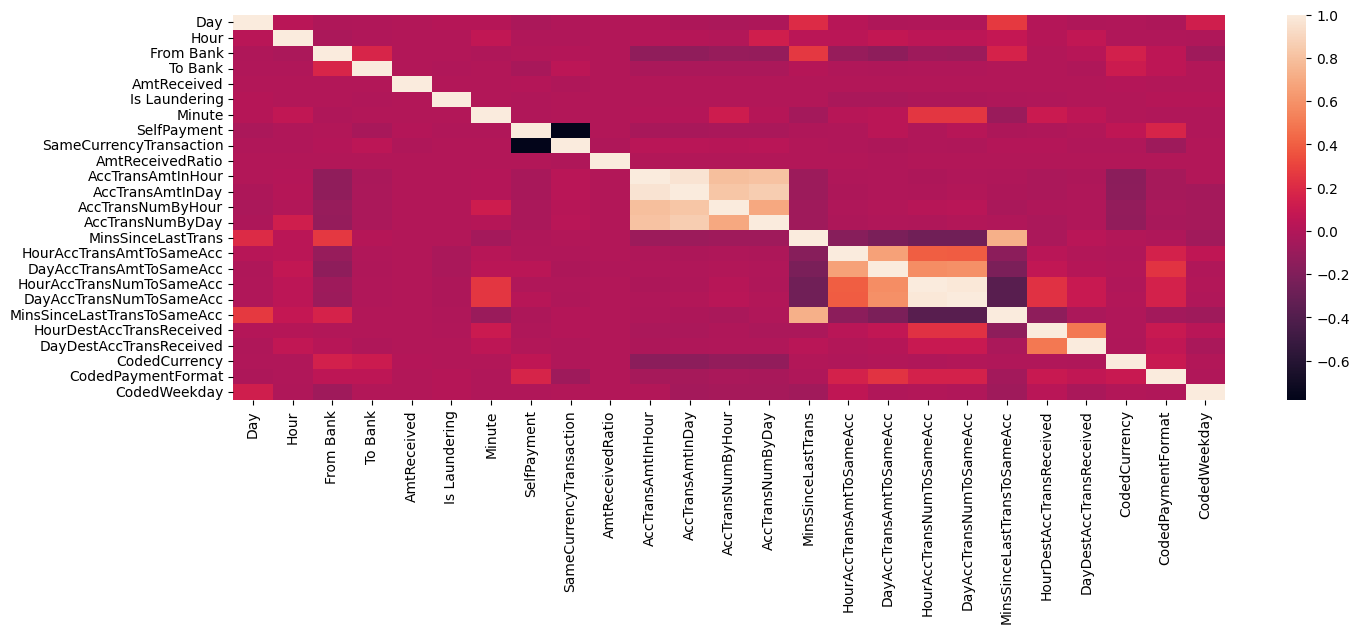

In [46]:
%%skip $skip_feature_viz
# Plot correlation matrix
plot_correlation_matrix(hi_small_model_input)

### Split and Save

After encoding, all that is left to do is split between training and testing, which is done with an 80% 20% split, and saving in the disk in parquet. We decided to save the dataset at this point to process all of the transformations overhead in advance instead of mixing the cost of applying the transformations with the model training.

In [47]:
hi_small_train, hi_small_test = hi_small_model_input.randomSplit([0.8, 0.2], seed=42)
# Save small data to parquet
hi_small_train.write.parquet("data/02_model_input/hi_small_train.parquet")
hi_small_test.write.parquet("data/02_model_input/hi_small_test.parquet")
del hi_small_train, hi_small_test, hi_small_model_input
gc.collect()

9689

In [48]:
%%skip $skip_medium_experiments
# This part may take an hour to complete, we are applying all transformations and saving
# to disk on a 1GB DS (Small) and 4GB DS (Medium). Consider skipping the execution of the
# medium experiment if you don't have the time.

# Save medium data to parquet
hi_medium_train, hi_medium_test = hi_medium_model_input.randomSplit([0.8, 0.2], seed=42)
hi_medium_train.write.parquet("data/02_model_input/hi_medium_train.parquet")
hi_medium_test.write.parquet("data/02_model_input/hi_medium_test.parquet")
del hi_medium_train, hi_medium_test, hi_medium_model_input
gc.collect()

# 1. Decision Tree

ALDER utilizes decision tree methods to predict money laundering in the created datasets. A decision tree is a flowchart-like tree structure where each internal node (non-leaf node) denotes a test on an attribute, each branch an outcome of the test, and each leaf a class label. Predictions of a class in a decision tree occur by traversing the tree from its root (top-most node) to a leaf, where for each internal node, the data point being predicted will perform a test on its attribute and decide the path to take until a classification is made.

## Iris Dataset

Even though the objective of the project is to classify the transactions in the IBM Transactions for Anti Money Laundering dataset, a good approach into developing a machine learning algorithm from scratch it to start developing it in a well controlled environment. Therefore, this project will use the Iris dataset to guide the development of a decision tree. This decision allow us to evaluate the implementation of the model in a common dataset which we know that the decision tree should perfom well. Therefore serving as a baseline and sanity check of the model implementation.

We will split the dataset into two. The first dataset will have the setosa and the versicolor while the second will have the versicolor and virginica. From the data visualization image the former dataset will be linear separable in multiple thus being easier to classify, while the latter is not linear separable thus probabliy more difficult.

- 0 = setosa
- 1 = versicolor
- 2 = virginica



In [49]:
# Load iris from sklearn datasets
iris = datasets.load_iris()

# Transform the format into pandas
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
# Fix label column
iris_df.target = iris_df.target.astype('int')

# Create two separeted dataset one of 0 and 1 labels, other with 1 and 2 labels
iris_easy = iris_df.loc[(iris_df.target == 0 )| (iris_df.target == 1)]
iris_hard = iris_df.loc[(iris_df.target == 1 )| (iris_df.target == 2)]

iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [50]:
# Auxiliary function to split the iris dataset
def split_test_val(data, label_col, val_rate = 0.3, seed=41):
  # Shuffle data
  data = data.sample(frac = 1, random_state=seed).reset_index(drop=True)
  # Get point of split
  split_index = int(np.round(len(data)*(1-val_rate)))
  # Get train and test data
  data_train = data[:split_index]
  data_val = data[split_index:]

  # Separate labels from features in the traning data
  train_X = data_train.drop(labels=label_col, axis=1)
  train_y = data_train[label_col]

  # Separate labels from features in the test data
  val_X = data_val.drop(labels=label_col, axis=1)
  val_y = data_val[label_col]

  return train_X, train_y, val_X, val_y


## The Tree Structure

The algorithm starts by initializing a node. A tree predictor has the structure of an ordered and rooted tree where each node is either a leaf (if it has zero children) or an internal node (if it has at least two children). The node is initialized as a leaf and can be substituted for an internal node later in execution. The idea is to grow the tree classifier starting from a single-node tree (which must be a leaf) that corresponds to the classifier assigning to any data point the label that occurs most frequently in the training set. The tree is grown recursively by picking a leaf and replacing it with an internal node and two new leaves. To account for replacing nodes from leaves to internal, ALDER implements the node as an abstract class cable of being both types of nodes. Therefore the node class has the properties: "Is Leaf", "Label" , "Feature" and "Threshold". If "Is"Leaf" is set to True, then the "Label" is assigned to a certain value, and the remaining properties are None. Otherwise, we set "Feature" and "Threshold" with appropriate values and set "Label" to None.

In [51]:
# The tree node class
class Node:
    def __init__(self, label=None, attribute=None, split_test=None):
        # Store the label if leaf node
        self.label = label
        # Store the attribute if internal node
        self.attribute = attribute
        # Store the attribute if internal node
        self.split_test = split_test
        # Boolean flag for Leafs
        self.is_leaf = True
        # Pointers to child nodes
        self.left_child = None
        self.right_child = None

## Building a Binary Tree

We devised a complete binary tree to work with discrete and continuous features that can use different impurity functions to handle information gain, class weights to handle class imbalance, approximation threshold methods for big data efficiency and multiple stopping criteria. The algorithm was constructed step-by-step, as demonstrated below, on top of the Iris dataset.

### Calculating the Training Error

Another important aspect to describe in the process of constructing a decision three is how the feature and threshold, with more information gain to split the data, are calculated. How we split the data will directly impact the model's training error. When a leaf does not contribute to the training error, we say that that leaf is pure. On the other hand, leaves that do contribute are impure; thus, we focus on measuring the impurity of the tree (the entropy). Additionally, the decision tree may also suffer from overfitting, which usually happens when the tree overgrows the cardinally of the training set. Therefore, choosing the leaf expansions guaranteeing the largest decrease in the training error is important.

Overall, the split's information gain is calculated as the difference between the parent's entropy and the children's weighted entropy. ALDER's implementation calculates the entropy with three possible approaches: Shannon, and Gini and Scaled Entropy.

In [52]:
def calculate_entropy(labels, func_type):
  # Get counts of zero and ones as vector
  _, counts = np.unique(labels, return_counts=True)
  # Normalize
  p_vec = counts / len(labels)

  # Calculate proper entropy criterion
  if func_type == 'shannon':
    return -np.sum(p_vec * np.log2(p_vec))
  elif func_type == 'scaled':
    return -np.sum((p_vec/2) * np.log2(p_vec))
  elif func_type == 'gini':
    return 1 - np.sum(np.square(p_vec))

def calculate_information_gain(data, labels, left_labels, right_labels, func_type):
    # Calculate entropy of the parent
    total_entropy = calculate_entropy(labels, func_type)
    # Calculate entropy of the children
    left_entropy = calculate_entropy(left_labels, func_type)
    right_entropy = calculate_entropy(right_labels, func_type)

    # Calculate weightes entropy of the children
    left_weighted_entropy = (len(left_labels) / len(labels)) * left_entropy
    right_weighted_entropy = (len(right_labels) / len(right_labels)) * right_entropy

    # Calculate the information gain
    information_gain = total_entropy - (left_weighted_entropy + right_weighted_entropy)
    return information_gain


### Attribute and Threshold Selection

The Algorithm belows shows ALDER's feature and threshold selection implementation. The process iterate for every possible feature in the data and get all the values of those features to calculate the candidate thresholds. Selecting a candidate threshold is an important step that can interfere significantly with the execution time. ALDER implements two methodologies of selecting threshold. The first is a naive approach that selects all unique values for the feature ordered and calculates the threshold as the middle distance between one data point and the other. This solution is not scalable for big data scenarios, where calculating the unique values every time is a cost-intensive operation, as well as looping through all possible unique values. With this in mind, ALDER also implements a technique suitable for big data (only in the final class, seen later).

After the candidate thresholds are calculated, the algorithm will loop through all the possible threshold values for that feature. It separates the left and right labels based on the current combination of features/thresholds, allowing the calculation of the information gain of a tree split with the current combination.


In [53]:
def select_attribute(data, labels, func_type):
    # Init best values
    best_feature = None
    best_threshold = None
    best_information_gain = -np.inf

    # Loop through features
    for feature in data.columns:

        # Get index of the column
        col_idx = data.columns.get_loc(feature)
        # Get possible values within this feature
        feature_values = data.iloc[:, col_idx]
        # Filter only the unique
        unique_values = np.unique(feature_values)
        # Get possible thresholds
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0

        # Calculate info gain of each threshold
        for threshold in thresholds:

            # Get the possible labels for the left node
            left_labels = labels[feature_values <= threshold]
            # Get the possible labels for the right node
            right_labels = labels[feature_values > threshold]

            # Calculate the information gain of the split
            information_gain = calculate_information_gain(data, labels, left_labels, right_labels, func_type)

            # Keep best information
            if information_gain > best_information_gain:
                best_feature = col_idx
                best_threshold = threshold
                best_information_gain = information_gain

    return best_feature, best_threshold

In order to perform a sanity test on the created algorithm, ALDER relies on a traditional dataset used in literature, the Iris. Even though Iris is not a binary classification problem, we can use it as a simple binary classification by removing one of the classes and considering only the non-linear separable remaining class. Figure bellow show a result of a single split values selection on the IRIS dataset. Notice that it finds the feature and the point where it best splits the data.

Best Feature: 3
Best Threshold: 1.75


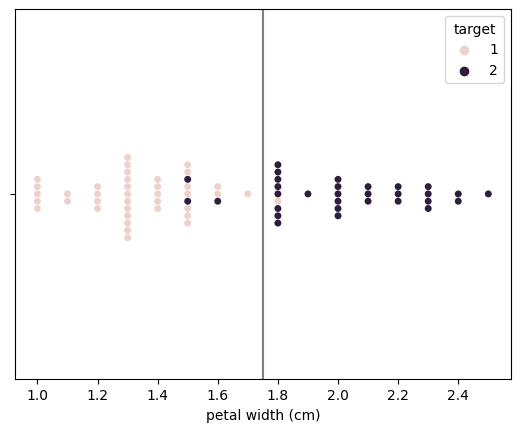

In [54]:
# Get best feature and best threshold of a sample data
data, labels, _, _ = split_test_val(iris_hard, 'target', val_rate = 0.3)
best_feature, best_treshold = select_attribute(data, labels, 'shannon')

# Print values
print(f"Best Feature: {best_feature}")
print(f"Best Threshold: {best_treshold}")

# Plot result
data["target"] = labels
plt.axvline(x=best_treshold, color='grey')
sns_plot = sns.swarmplot(data=data, x=data.columns[best_feature], hue="target")

### Stopping Criterias

ALDER implement three types of stopping criteria to handle overfitting and controlling the training process. The first and most trivial is stopping if our data partition contains only a single label and therefore does not need further splitting. The second is considering the maximum depth of the tree. In order to avoid growing the tree infinitely until finding individual partitions, we set a maximum size for the tree to grow. This stop criteria also allows to control the overfitting of the tree. Finally, we consider a third stopping criteria, which also allows for controlling overfitting, considering the minimum amount of samples in a split. This approach will stop growing a tree even if the label is not unique. Thus finding the right value for this parameter will help create a proper balance between acceptable mistakes and generalization.

In [55]:
def max_depth_stop(depth, max_depth):
  # Check for max depth
  return depth==max_depth

def no_labels_to_split_stop(labels):
  # Check for unique labels
  return len(np.unique(labels)) == 1

def min_samples_split_stop(labels, min_samples_per_split):
  # Calculate if labels are smaller than the minimum samples
  return len(labels) < min_samples_per_split

### Building the Tree

The algorithm starts by initializing a node. A tree predictor has the structure of an ordered and rooted tree where each node is either a leaf (if it has zero children) or an internal node (if it has at least two children). The node is initialized as a leaf and can be substituted for an internal node later in execution.

After initializing the node, we check the algorithm for stopping criteria. Since this algorithm is recursive, we might be at a point at the execution heap where we need to stop constructing the tree in depth and return a leaf node.

If any stop criteria are met, we assigns the most common label of the data partition and returns the node. On the other hand, if we have not reached a stopping point, the algorithm looks for features and thresholds with more information gained to split the data. After the feature and threshold are computed, we assign the selected values to the node and set that the node is not a leaf anymore. We split the remaining data and labels with the node split conditions now assigned. The data/labels with the select feature below or equal to the select threshold are used to create the left child, and the data/labels with the select feature above the select attribute are used to create the right child. Thus, we recursively call the algorithm for each of the nodes children and since we are implementing a binary tree, this function will only split into two subsets. while calling the build tree function for the children, we also increase the depth counter to stop when maximum depth is reached eventually.

In [56]:
def build_decision_tree(data, labels, depth=0, max_depth=10, min_samples_per_split=2, func_type='shannon'):
    # Initialize an empty root node
    node = Node()

    # Test for the stop critereas
    if max_depth_stop(depth, max_depth) or no_labels_to_split_stop(labels) or min_samples_split_stop(labels, min_samples_per_split):
        # If one of the criteras is met assign the node label
        # as the most frequent in the label subset
        node.label = np.bincount(labels).argmax()
        return node

    # Attribute selection
    best_feature, best_threshold = select_attribute(data, labels, func_type)
    # Assign results to nod
    node.attribute = best_feature
    node.split_test = best_threshold
    node.is_leaf = False


    # Split the data to create left and right indices based on the selected attribute and threshold
    left_indices = data.iloc[:, best_feature] <= best_threshold
    right_indices = data.iloc[:, best_feature] > best_threshold

    # Get left and right data and labels
    left_data, left_labels = data.loc[left_indices], labels.loc[left_indices]
    right_data, right_labels = data.loc[right_indices], labels.loc[right_indices]

    # Recursively build the left and right subtrees
    if len(left_data) > 0:
        node.left_child = build_decision_tree(left_data, left_labels, depth = depth+1,
                                              max_depth=max_depth, min_samples_per_split=min_samples_per_split, func_type=func_type)
    if len(right_data) > 0:
        node.right_child = build_decision_tree(right_data, right_labels, depth = depth+1,
                                               max_depth=max_depth, min_samples_per_split=min_samples_per_split, func_type=func_type)

    return node


In [57]:
# Create easy iris ds decision tree
easy_train_X, easy_train_y, easy_test_X, easy_test_y = split_test_val(iris_easy, 'target', val_rate = 0.3)
easy_tree = build_decision_tree(easy_train_X, easy_train_y, max_depth=1)

# Create hard iris ds decision tree
hard_train_X, hard_train_y, hard_test_X, hard_test_y = split_test_val(iris_hard, 'target', val_rate = 0.3)
hard_tree = build_decision_tree(hard_train_X, hard_train_y, max_depth=10)

#### Viewing Iris Trees

As an auxiliary method of visualizing the process of creating a tree, we also provided a function to print the resulting tree.


In [58]:
def print_decision_tree(node, columns, indent=""):
    if node.is_leaf:
        print(indent + "Label:", node.label)
        return

    if not node.is_leaf:
        print(indent + columns[node.attribute] + " <= " + str(node.split_test))

    print(indent + "Left:")
    print_decision_tree(node.left_child, columns, indent + "  ")

    print(indent + "Right:")
    print_decision_tree(node.right_child, columns, indent + "  ")

print_decision_tree(hard_tree, hard_train_X.columns)

petal width (cm) <= 1.75
Left:
  sepal length (cm) <= 7.1
  Left:
    sepal width (cm) <= 2.8499999999999996
    Left:
      sepal width (cm) <= 2.25
      Left:
        petal length (cm) <= 4.75
        Left:
          Label: 1
        Right:
          Label: 2
      Right:
        petal width (cm) <= 1.55
        Left:
          petal length (cm) <= 5.0
          Left:
            Label: 1
          Right:
            Label: 2
        Right:
          Label: 1
    Right:
      Label: 1
  Right:
    Label: 2
Right:
  petal length (cm) <= 4.85
  Left:
    sepal length (cm) <= 5.95
    Left:
      Label: 1
    Right:
      Label: 2
  Right:
    Label: 2


## Predict & Error in Iris

Finally, to perform a prediction over the data, ALDER transverses the tree for every data point in the prediction set, performing the necessary evaluation of the feature for each internal node. As a result, demonstrating empirically that the constructed algorithm is sound, the training error on the non-linear separable Iris subset was $0.0$, and the test error of $0.03$.

In [59]:
# Predict a single instance
def _predict_single(node, instance):
    # If node is label return the prediction
    if node.label is not None:
        return node.label

    # If node is internal check for the feature/threshold combination on data
    # and choose left or right path
    if instance[node.attribute] <= node.split_test:
        return _predict_single(node.left_child, instance)
    else:
        return _predict_single(node.right_child, instance)

def predict(root_node, data):
  # Execute predictions for every data by iterating the dataset
  predictions = [_predict_single(root_node, instance[1]) for instance in data.iterrows()]
  return predictions

def calculate_error(predictions, labels):
    # Calculate the error of the predictions
    wrong_predictions = np.sum(predictions != labels)
    error = wrong_predictions / len(labels)
    return error

# Predict and calculate training and testing error for easy Iris
easy_train_preds = predict(easy_tree, easy_train_X)
easy_test_preds = predict(easy_tree, easy_test_X)
error_easy_train = calculate_error(easy_train_preds, easy_train_y)
error_easy_test = calculate_error(easy_test_preds, easy_test_y)

# Predict and calculate training and testing error for medium Iris
hard_train_preds = predict(hard_tree, hard_train_X)
hard_test_preds = predict(hard_tree, hard_test_X)
error_hard_train = calculate_error(hard_train_preds, hard_train_y)
error_hard_test = calculate_error(hard_test_preds, hard_test_y)

# Print the results
print(f"Linear Separable IRIS Set: Training Error {error_easy_train}; Test Error: {error_easy_test}")
print(f"Non Linear Separable IRIS Set: Training Error {error_hard_train}; Test Error: {error_hard_test}")

Linear Separable IRIS Set: Training Error 0.0; Test Error: 0.0
Non Linear Separable IRIS Set: Training Error 0.0; Test Error: 0.03333333333333333


## The DecisionTree Class

Among multiple devised algorithms for the creation of decision trees, the most common are the ID3, C4.5 and CART. The ID3 algorithm, developed by Quinlan, introduced the concept of decision trees and information gain as a criterion for attribute selection. It focused on recursively partitioning the data based on the most informative attributes to create a decision tree. C4.5 is an extension of the ID3 algorithm also proposed by Quinlan that introduced several improvements and new features, including handling missing values, handling continuous attributes, pruning decision trees to prevent overfitting, and incorporating cost-based learning. Finally, the CART algorithm, developed by Leo Breiman, Jerome Friedman, Richard Olshen, and Charles Stone, presents a framework for building decision trees that can be used for both classification and regression tasks. The paper describes the methodology of constructing binary recursive partitioning trees using Gini impurity as the criterion for attribute selection.

ID3, C4.5 and CART adopt a greedy approach in which decision trees are constructed in a top-down recursive divide-and-conquer manner. ALDER's decision tree implementation is more closely related to the C4.5 algorithm with multiple simplifications and additions. Specifically, we devised a complete binary tree to work with discrete and continuous features that can use different impurity functions to handle information gain, class weights to handle class imbalance, approximation threshold methods for big data efficiency and multiple stopping criteria.

In [60]:
def calculate_error(predictions, labels):
    # Calculate the error of the predictions
    wrong_predictions = np.sum(predictions != labels)
    error = wrong_predictions / len(labels)
    return error

def accuracy(predictions, labels):
    # Calculate the accuracy of the predictions
    correct_predictions = np.sum(predictions == labels)
    return correct_predictions / len(labels)

def precision(predictions, labels):
    # Calculate the precision of the predictions
    tp = np.sum((predictions == 1) & (labels == 1))
    fp = np.sum((predictions == 1) & (labels == 0))
    return (tp / (tp + fp))

def recall(predictions, labels):
    # Calculate the recall of the predictions
    tp = np.sum((predictions == 1) & (labels == 1))
    fn = np.sum((predictions == 0) & (labels == 1))
    return tp / (tp + fn)

def f1_score(predictions, labels):
    # Calculate the f1-score of the predictions
    prec = precision(predictions, labels)
    rec = recall(predictions, labels)
    return  2 * (prec * rec) / (prec + rec)

class Node:
    # The tree node class
    def __init__(self, label=None, attribute=None, split_test=None):
        # Store the label if leaf node
        self.label = label
        # Store the attribute if internal node
        self.attribute = attribute
        # Store the attribute if internal node
        self.split_test = split_test
        # Boolean flag for Leafs
        self.is_leaf = True
        # Pointers to child nodes
        self.left_child = None
        self.right_child = None

class DecisionTree:
  # Encapsulate all the decision tree functions in a class
  def __init__(self, verbose=1, max_depth=10, min_samples_per_split=2, func_type='shannon', tree_id=0,
               threshold_method='all', threshold_buckets=10, class_weights=[], display_metrics='full'):
    # Set max depth of the tree
    self.max_depth = max_depth
    # Set min samplest per split
    self.min_samples_per_split = min_samples_per_split
    # Set function type: (shannon, gini, scaled)
    self.func_type = func_type
    # Set threshold method (bigdata or complete)
    self.threshold_method = threshold_method
    # Set amount of buckets for bigdata threshold
    self.n_buckets = threshold_buckets
    # Set verbose method
    self.verbose = verbose
    # Set class weights of the training data
    self.class_weights = class_weights
    # Set display metrics flag
    self.display_metrics = display_metrics
    # Set id of the forest in case we are using a random forest
    self.tree_id = tree_id
    # References for the data model when tree is fit
    self.cols = None
    self.root = None

  def fit(self, data, label):
    # Save the data columns
    self.cols = data.columns
    # Create the tree and save the root
    self.root = self._build_decision_tree(data, label)

    # If verbose also predict the training data
    if self.verbose==1:
      preds = self.predict(data, label)

    # Return the class object itself
    return self

  def predict(self, data, labels=[]):
    # Raise error in case someone try to predict a unfitted model
    if not self.root:
      raise NotImplementedError("Model not yet fitted.")

    # Predict over the dataset using the apply function
    predictions = data.apply(lambda row: self._predict_single(self.root, row), axis=1)

    # If labels are passed to the predict parameter: print metrics
    if len(labels):
      DecisionTree.calc_metrics(predictions, labels, self.display_metrics, self.tree_id)

    return predictions

  def print_tree(self, node=None, indent=""):
      # Print the tree

      # Raise error in case someone try to predict a unfitted model
      if not self.root:
        raise NotImplementedError("Model not yet fitted.")

      # First case, pass root
      if not node:
        node = self.root

      # If node is leaf print label of the leaf
      if node.is_leaf:
          print(indent + "Label:", node.label)
          return

      # If node is interal ident and print the spliting conditiong
      if not node.is_leaf:
          print(indent + self.cols[node.attribute] + " <= " + str(node.split_test))

      # Print nodes left and right children
      print(indent + "Left:")
      self.print_tree(node.left_child, indent + "  ")
      print(indent + "Right:")
      self.print_tree(node.right_child, indent + "  ")

  @staticmethod
  def calc_metrics(preds, label, display_metrics, tree_id=0):
    # Calculate prediction metrics
    preds = np.array(preds, dtype='int')
    label = label.to_numpy()

    # Full mode display
    if display_metrics == 'full':
      print(f"Model Error: {calculate_error(preds, label)}")
      print(f"Model Accuracy: {accuracy(preds, label)}")
      print(f"Model Precision: {precision(preds, label)}")
      print(f"Model Recall: {recall(preds, label)}")
      print(f"Model F1-Score: {f1_score(preds, label)}")
    # Compact display for random forests
    if display_metrics == 'random_forest':
      print(f"[Worker {tree_id}] F1-Score: {f1_score(preds, label)}")
      print(f"[Worker {tree_id}] Recall: {recall(preds, label)}")
      print(f"[Worker {tree_id}] Precission: {precision(preds, label)}")
      print(f"[Worker {tree_id}] Accuracy: {accuracy(preds, label)}")

    return preds


  def _calculate_entropy(self, labels):
    # Internal method to calculate the entropy

    # Get counts of zero and ones as vector
    values, counts = np.unique(labels, return_counts=True)

    # Normalize
    p_vec = counts / len(labels)

    # Apply class weights if set
    if len(self.class_weights) and len(p_vec):
      weights = self.class_weights
      if len(values) == 1:
        weights = self.class_weights[values[0]]
      p_vec = p_vec*weights

    # Calculate proper entropy criterion
    if self.func_type == 'shannon':
      return -np.sum(p_vec * np.log2(p_vec))
    elif self.func_type == 'scaled':
      return -np.sum((p_vec/2) * np.log2(p_vec))
    elif self.func_type == 'gini':
      return 1 - np.sum(np.square(p_vec))

  def _calculate_information_gain(self, data, labels, left_labels, right_labels):
    # Internal method to calculate the information gain

    # Calculate entropy of the parent
    total_entropy = self._calculate_entropy(labels)
    # Calculate entropy of the children
    left_entropy = self._calculate_entropy(left_labels)
    right_entropy = self._calculate_entropy(right_labels)

    # Calculate weightes entropy of the children
    left_weighted_entropy = (len(left_labels) / len(labels)) * left_entropy
    right_weighted_entropy = (len(right_labels) / len(labels)) * right_entropy
    # Calculate the information gain
    information_gain = total_entropy - (left_weighted_entropy + right_weighted_entropy)
    return information_gain

  def _select_attribute(self, data, labels):
    # Internal method for selecting the attribute

    # Init best values
    best_feature = None
    best_threshold = None
    best_information_gain = -np.inf

    # Iterate through features in the dataset
    for feature in data.columns:
        # Get index of the column
        col_idx = data.columns.get_loc(feature)
        # Get possible values within this feature
        feature_values = data.iloc[:, col_idx]
        # Filter only the unique
        thresholds = []
        if self.threshold_method == 'all':
          # Get unique values
          unique_values = np.unique(feature_values)
          # Get possible thresholds
          thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0
        elif self.threshold_method == 'bigdata':
          # Get percentiles thresholds
          thresholds = np.percentile(feature_values, np.linspace(0, 100, self.n_buckets))

        # Calculate info gain of each threshold
        for threshold in thresholds:
            # Get the possible labels for the left node
            left_labels = labels[feature_values <= threshold]
            # Get the possible labels for the right node
            right_labels = labels[feature_values > threshold]

            # Calculate the information gain of the split
            information_gain = self._calculate_information_gain(data, labels, left_labels, right_labels)

            # Keep the values for the best information gain
            if information_gain > best_information_gain:
                best_feature = col_idx
                best_threshold = threshold
                best_information_gain = information_gain

    return best_feature, best_threshold

  def _max_depth(self, depth):
    # Internal method stop condition for max depth
    return depth==self.max_depth

  def _no_labels_to_split(self, labels):
    # Internal method stop condition for no more labels to split
    return len(np.unique(labels)) == 1

  def _min_samples_split(self, labels):
    # Internal method stop condition for minimum ammount of labels per split
    return len(labels) < self.min_samples_per_split

  def _build_decision_tree(self, data, labels, depth=0):
    # Initialize an empty root node
    node = Node()

    # Test for the stop critereas
    if self._max_depth(depth) or self._no_labels_to_split(labels) or self._min_samples_split(labels):
        # If one of the criteras is met assign the node label
        # as the most frequent in the label subset
        node.label = np.bincount(labels).argmax()
        return node

    # Attribute selection
    best_feature, best_threshold = self._select_attribute(data, labels)
    # Assign results to node
    node.attribute = best_feature
    node.split_test = best_threshold
    node.is_leaf = False


    # Split the data to create left and right indices based on the selected attribute and threshold
    left_indices = data.iloc[:, best_feature] <= best_threshold
    right_indices = data.iloc[:, best_feature] > best_threshold

    # Get left and right data and labels
    left_data, left_labels = data.loc[left_indices], labels.loc[left_indices]
    right_data, right_labels = data.loc[right_indices], labels.loc[right_indices]

    # Recursively build the left and right subtrees
    if len(left_data) > 0:
        node.left_child = self._build_decision_tree(left_data, left_labels, depth = depth+1)
    else:
        # Assign a default label to handle empty left_data
        unique_labels, label_counts = np.unique(labels, return_counts=True)
        node.left_child = Node(label=unique_labels[np.argmax(label_counts)])

    if len(right_data) > 0:
        node.right_child = self._build_decision_tree(right_data, right_labels, depth = depth+1)
    else:
        # Assign a default label to handle empty right_data
        unique_labels, label_counts = np.unique(labels, return_counts=True)
        node.right_child = Node(label=unique_labels[np.argmax(label_counts)])

    return node

  def _predict_single(self, node, instance):
    # Internal method for predict a single instance

     # If node is label return the prediction
    if node.label is not None:
        return node.label

    # If node is internal check for the feature/threshold combination on data
    # and choose left or right path
    if instance[node.attribute] <= node.split_test:
        return self._predict_single(node.left_child, instance)
    else:
        return self._predict_single(node.right_child, instance)

In order to perform a sanity test on the created algorithm, ALDER relies on the Iris dataset. As a result, demonstrating empirically that the constructed algorithm is sound, the training error on the non-linear separable Iris subset was $0.0$, and the test error of $0.03$.

In [61]:
# Split iris dataset into train/test with 70/30
hard_train_X, hard_train_y, hard_test_X, hard_test_y = split_test_val(iris_hard, 'target', val_rate = 0.3)
hard_train_y[hard_train_y == 2] = 0
hard_test_y[hard_test_y == 2] = 0

# Initialize the classifier
clf = DecisionTree()

# Fit
print("Training:")
clf = clf.fit(hard_train_X, hard_train_y)

# Predict
print("\nTest:")
preds = clf.predict(hard_test_X, hard_test_y)

Training:
Model Error: 0.0
Model Accuracy: 1.0
Model Precision: 1.0
Model Recall: 1.0
Model F1-Score: 1.0

Test:
Model Error: 0.03333333333333333
Model Accuracy: 0.9666666666666667
Model Precision: 0.9166666666666666
Model Recall: 1.0
Model F1-Score: 0.9565217391304348


## IBM AML Decision Tree


Our first experiment tested a single decision tree in the IBM TAML data, especially the small dataset. This experiment was designed to answer the a research question on whether the devised decision tree can learn to detect money laundering. For this experiment, we considered only a fraction of the small dataset. Even though the dataset can be completely loaded into memory, its execution would take time. Therefore the experiment is run with 50% of the training set and 50% of the testing set. Notice that it does not change the proposed 80%-20% data division.

In [62]:
hi_small_train = spark.read.parquet('./data/02_model_input/hi_small_train.parquet')
hi_small_train_pandas = hi_small_train.sample(fraction=0.5, seed=42).toPandas()


hi_small_test = spark.read.parquet('./data/02_model_input/hi_small_test.parquet')
hi_small_test_pandas = hi_small_test.sample(fraction=0.5, seed=42).toPandas()

label_counts = hi_small_train_pandas["Is Laundering"].value_counts()
hi_class_weights = [1.0, label_counts[0]/label_counts[1]]
print(label_counts)
print(hi_class_weights)

0    1836583
1       2024
Name: Is Laundering, dtype: int64
[1.0, 907.4026679841897]


 Overall the model achieved an F1-Score of 0.6751 on training that decreased to 0.5990 on the test set, a Recall of 0.5237 on training and 0.4631 in test, and a Precision of 0.9498 on train and 0.8477 on test. These values are a good indication of the training process. We notice that the decision tree overall was able to learn but with a higher focus on precision rather than the recall, and the lack of focus on the recall decreases the F1-Score. However, we also notice that the difference between the training and testing metrics is not significant, showing that the model was able to generalize. Therefore, this model has a higher bias for the F1-Score but a low variance.

In [63]:
hi_train_X = hi_small_train_pandas.drop(labels=["Is Laundering"], axis=1)
hi_train_y = hi_small_train_pandas["Is Laundering"]
hi_test_X = hi_small_test_pandas.drop(labels=["Is Laundering"], axis=1)
hi_test_y = hi_small_test_pandas["Is Laundering"]

clf = DecisionTree(max_depth=16, threshold_method='bigdata', threshold_buckets=20, class_weights=hi_class_weights, min_samples_per_split=14)
clf = clf.fit(hi_train_X, hi_train_y)

Model Error: 0.0005547678215083484
Model Accuracy: 0.9994452321784917
Model Precision: 0.9498207885304659
Model Recall: 0.5237154150197628
Model F1-Score: 0.6751592356687897


In [64]:
preds = clf.predict(hi_test_X, hi_test_y)

Model Error: 0.000712246072332063
Model Accuracy: 0.9992877539276679
Model Precision: 0.8477508650519031
Model Recall: 0.46313799621928164
Model F1-Score: 0.5990220048899755


We can analyze the results further by looking at the confusion matrix. As we can see, the matrix reflects the metrics. Since the recall is slightly below 0.5, we can observe that false negatives are slightly higher than true positives. Additionally, we see only 44 transactions mistakenly being predicted as fraudulent, which is a result of our higher precision. Therefore, ALDER can learn without significant false alarms, however, with some considerable misses.

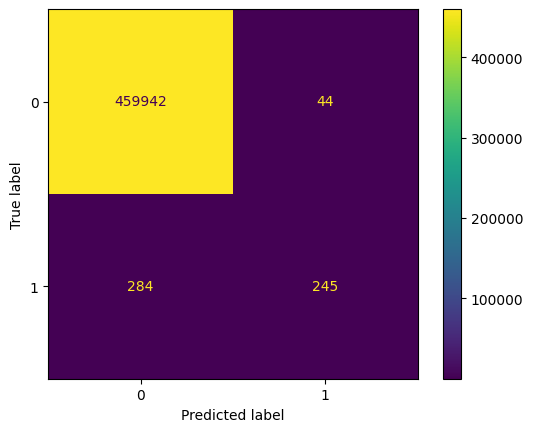

In [65]:
cm = confusion_matrix(hi_test_y, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot();

In [66]:
# Get back the memory
del hi_small_train_pandas, hi_small_test_pandas, hi_train_X, hi_train_y, hi_test_X, hi_test_y, preds
gc.collect();

### Hyperparameter Optimization with Hyperopts


Finding an optimum set of hyperparameters is an essential task to achieve model performance, since setting the hyperparameters in the wrong way can lead to underfitting or overfitting. ALDER selects the best set of hyperparameters in a given search space by taking advantage of the Hyperopt: Distributed Asynchronous Hyper-parameter Optimization.

[Hyperopt](http://hyperopt.github.io/hyperopt/) is a python library that implements Sequential Model-Based Optimization (SMBO) algorithms. Such method uses a search algorithm to determine hyper-parameters through search interactions denominated trials.


The Hyperopt experiment was conducted offline in a Macbook Air M2 8-Core CPU with 32GB RAM. The reasoning of not using the Colab to perform the hyperparameter tuning is two-fold: it would take a considered amount of time to complete and the Macbook has faster processing and more available memory. The hyperparameter optimization was performed with the complete small dataset in memory.

```python
from hyperopt import hp
from hyperopt import fmin, tpe, Trials

hi_small_train = spark.read.parquet('./data/02_model_input/hi_small_train.parquet')
hi_small_train_pandas, hi_small_test_pandas = hi_small_train.randomSplit([0.8, 0.2], seed=42)

hi_small_train_pandas = hi_small_train_pandas.toPandas()
hi_small_test_pandas = hi_small_test_pandas.toPandas()

hi_train_X = hi_small_train_pandas.drop(labels=["Is Laundering"], axis=1)
hi_train_y = hi_small_train_pandas["Is Laundering"]
hi_test_X = hi_small_test_pandas.drop(labels=["Is Laundering"], axis=1)
hi_test_y = hi_small_test_pandas["Is Laundering"]

label_counts = hi_small_train_pandas["Is Laundering"].value_counts()
hi_class_weights = [1.0, label_counts[0]/label_counts[1]]
normal_weights = [1.0, 1.0]
```

The usage of the Hyperopt library is based on defining three main characteristics:

1. an objective function value to be minimized;

```python

def objective(params):
    # Train your model with the given hyperparameters
    max_depth = params['max_depth']
    buckets = params['buckets']
    min_samples_per_split = params['min_samples_per_split']
    func_type = params['func_type'],
    func_type = func_type[0]
    hi_class_weights = list(params['class_weights'])


    # Your model training code goes here
    clf = DecisionTree(max_depth=max_depth, threshold_method='bigdata', threshold_buckets=buckets,                      
                       class_weights=hi_class_weights, min_samples_per_split=min_samples_per_split,
                       func_type=func_type, verbose=0)
    clf = clf.fit(hi_train_X, hi_train_y)
    preds = clf.predict(hi_test_X)

    obj = f1_score(preds, hi_test_y)
    
    print(f"Func: {func_type}; Depth: {max_depth}; Buckets: {buckets}; Min Samples: {min_samples_per_split}; Class Weights: {hi_class_weights}     ->    F1={-obj}")
    
    # Return the evaluation metric you want to optimize (e.g., validation loss)
    return -obj
```

2. the search space for the selected algorithm.

```python
space = {
    'max_depth': hp.choice('max_depth', list(range(5, 21))),
    'buckets': hp.choice('buckets', list(range(5, 51, 5))),
    'min_samples_per_split': hp.choice('min_samples_per_split', list(range(2, 15))),
    "func_type": hp.choice('func_type', ['gini', 'shannon', 'scaled']) ,
    "class_weights": hp.choice('class_weights', [hi_class_weights, normal_weights])
}
```


3. a search algorithm used to find the optimization set; The Tree Parzen estimator is a widely used Bayesian optimization method that has achieved various outstanding performances and have been the key factor of winning multiple Kaggle competitions.


```python
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

best_hyperparams = {k: v for k, v in best.items()}
print("Best Hyperparameters:", best_hyperparams)
```

The experiments were executed with 100 trials and the training set was further split into training and validation. Therefore, for the hyperparameter tuning we considered a 60% 20% 20% training, validation, test split, as proposed for this dataset.  The best set of hyperparameters achieved a F1-Score of 0.64468 in the validation set and consisted of the following configuration: Maximum Depth: 18; Minimum Samples per Split: 14; Amount of Thresholds: 45; Class Weights: With Weights; Impurity Function: Shannon. However, considering the execution time cost, we decided to select a second best set of parameter which achieved a F1-Score of $0.6400$ which consisted of the following configuration: 16 depth, minimum of 14 samples per split; 20 thresholds; class weights and Shannon function.


# 2. Distributed Workers

With the decision tree model created, ALDER is ready to handle Random Forests. Random Forest is one kind of ensemble method, a technique that combines a series of learning models intending to create an improved composite model that outperforms a single classifier. In the case of the Random forest, each model is a single decision tree so that the collection of classifiers is a "forest" ALDER individual decision trees are generated using a random selection of the data features for each tree. During the classification, each tree in the forest has its own vote, and the mode of the votes of the trees is selected as the final classification.

## Dataset Preparation

ALDER's Random Forest techniques are built using Bagging. Given a complete training set, we generate multiple bootstrap sampled training sets to be used for each tree. A bootstrap sampled training set is a subset of the complete training set sampled with replacement, where some of the samples in the complete set will not occur in the subset, and some may occur more than once. Additionally, the bagging methodology allows us to create multiple sub-datasets which could load in the primary memory of each worker in a scenario where the complete big dataset would not.

In [67]:
def bootstrap_sample_rows(dataset, seed, sample_ratio=0.3):
   # Get a sample with replacement of the available rows, seeded with the workerid
   sampled_ds = dataset.sample(withReplacement=True, fraction=sample_ratio, seed=seed)
   return sampled_ds

def sample_columns(dataset, label_col, seed, sample_ratio=0.6):
    # Set random seed
    rng = random.Random(seed)
    # Subtract 1 to exclude the label column
    num_cols = len(dataset.columns) - 1
    # Get column names, except for the label
    features_columns = [col for col in dataset.columns if col != label_col]
    # Shuffle Names
    rng.shuffle(features_columns)
    # Get first %
    selected_cols = features_columns[:int(num_cols * sample_ratio)]
    # Sample the dataset
    sampled_dataset = dataset.select(selected_cols)
    sampled_label = dataset.select(label_col)

    return sampled_dataset, sampled_label

In [68]:
def create_training_data(dataset, ds_params, worker_id):
    # Subsample the dataset using bootstrap sampling
    sampled_ds = bootstrap_sample_rows(dataset, seed=worker_id,
                                       sample_ratio=ds_params["row_frac"])

    # Select a subset of columns for the current tree
    sampled_ds, sampled_label = sample_columns(sampled_ds, ds_params["label"],
                                               seed=worker_id,
                                               sample_ratio=ds_params["col_frac"])

    return sampled_ds, sampled_label

def create_test_data(dataset, ds_params):
    # Calculate the length of the batch by splitting the size by the amount of batches
    batch_len = dataset.count() // ds_params["num_batches"]

    # Generate lazy evaluated dataset chunks
    chunks = []
    for i in range(ds_params["num_batches"]):
        chunk = dataset.limit(batch_len)
        dataset = dataset.subtract(chunk)
        chunks.append(chunk)

    return chunks

## Train Trees

In the case of the Random forest, each model is a single decision tree so that the collection of classifiers is a "forest". ALDER cistribute the creation of the decision trees to its available workers. The worker is responsible to loading the distributed data into its own primary memory and construct a tree.

In [69]:
# Function to train a single tree on a worker
# This function should be distributed to each worker and executed in parallel.
def train_tree(worker_id, dataset, tree_params):
    # Prepare data for training
    print(f"[Worker {worker_id}] Preparing Data")
    data_X, data_y = dataset

    # Load the data into memory
    data_X = data_X.toPandas()
    data_y = data_y.toPandas().squeeze()

    # Train the tree on the sampled dataset
    print(f"[Worker {worker_id}] Creating Tree")
    tree = DecisionTree(max_depth=tree_params["max_depth"],
                        threshold_method=tree_params["threshold"],
                        threshold_buckets=tree_params["buckets"],
                        min_samples_per_split=tree_params["min_samples_per_split"],
                        tree_id=tree_params["tree_id"],
                        display_metrics=tree_params["disp_mode"],
                        func_type=tree_params["func_type"],
                        class_weights=tree_params["weights"])
    model = tree.fit(data_X, data_y)

    return model

## Predict

ALDER prediction for the random forest is performed in batches. Since all trees must predict all test data, loading all data in memory at once may be unfeasible in big data scenarios. Handling this issue, the random forest predicts data in batches. After every tree predicted the data of the first batch, we start processing the next batch until there are no more batches to predict.

In [70]:
def tree_predict(decision_tree, data, test_set_params):

    # Get proper column sampling for the given decision tree
    print(f"[Worker {test_set_params['tree_id']}] Creating Data")
    feature_data, _ = sample_columns(data, test_set_params["label"],
                                          seed=test_set_params["tree_id"],
                                          sample_ratio=test_set_params["col_frac"])
    # Load in Memory
    feature_data = feature_data.toPandas()

    # Calculate the predictions
    print(f"[Worker {test_set_params['tree_id']}] Predicting")
    preds = decision_tree.predict(feature_data)

    return preds

def rf_predict(random_forest, chunk, test_set_params):

    # Init chunk predictions vector
    chunk_preds = []

    # For each worker, predict data in the chunk
    for worker in random_forest:
        test_set_params["tree_id"] = worker
        preds = tree_predict(random_forest[worker], chunk, test_set_params)
        chunk_preds.append(preds)

    # Get final vote of the chunk by calculating the mode of the workers predictions
    final_preds = stats.mode(chunk_preds, keepdims=True).mode[0]

    return final_preds



## Distribute Processing

The idea of the random forests algorithm works side-by-side with the concepts of distributed processing and big data. Due to its multiple model characteristics, it is intuitive to parallelize the construction of the model by distributing the creation of individual decision trees to multiple available workers.

In [71]:
# Handle the distribution of the processing to each worker
def distribute_training(dataset, ds_params, tree_params, workers=4):

  # Initialize workers
  worker_ids = range(workers)

  # Init a dict to save the workers models
  models = {}

  for worker in worker_ids:
    # Prepare the workers data
    worker_data = create_training_data(dataset, ds_params, worker_id=worker)
    # Send the data for the worker function to train the tree
    tree_params["tree_id"] = worker
    tree = train_tree(worker, worker_data, tree_params)
    models[worker] = tree

  return models

In [72]:
# Handle the distribution of the prediciton to each worker
def distribute_predict(random_forest, test_set, test_set_params):

  # Prepare the data chunks
  print("[Cluster Manager] Creating Data Chunks")
  chunks_data = create_test_data(test_set, test_set_params)
  print(f"[Cluster Manager] {len(chunks_data)} Chunks Created")

  predictions = []

  # For each chunk call the prediction function and save the predictions of the chunk
  for chunk in range(len(chunks_data)):
    print(f"[Cluster Manager] Distributing Chunk {chunk}")
    preds = rf_predict(random_forest, chunks_data[chunk], test_set_params)
    predictions.append(preds)

  # Generate a single prediction list
  predictions = np.concatenate(predictions)

  # Get the label vector for the dataset
  print("[Cluster Manager] Fetching Labels")
  labels = test_set.select(test_set_params["label"]).toPandas().squeeze()

  # Print Metrics
  print("[Cluster Manager] Calculating Metrics")
  DecisionTree.calc_metrics(predictions, labels, 'full')

  return predictions, labels


## Small DS Random Forest

Given the satisfactory results in the single decision tree process, we implemented the first experiment with a random forest. This experiment was designed to understand if the random forest could learn in a distributed environment for the small dataset and if the distributed random forest outperforms the single decision tree experiment.


In [73]:
# Load the data
hi_small_train = spark.read.parquet('./data/02_model_input/hi_small_train.parquet')
hi_small_test = spark.read.parquet('./data/02_model_input/hi_small_test.parquet')

# Count the labels to generate the class weights
label_counts_small = hi_small_train.groupBy("Is Laundering").count().cache()
zero_class_small = label_counts_small.where(col("Is Laundering") == 0).collect()[0]['count']
one_class_small = label_counts_small.where(col("Is Laundering") == 1).collect()[0]['count']

# Assign class weights
class_weights_small = [1.0, zero_class_small/one_class_small]

For the random forest experiments, we had to configure an additional set of parameters, those being: the number of workers (which is the same as the number of decision trees in the forest), the size of the column subsampling and the size of the row bootstrap subsampling. Considering the small dataset, each decision tree is trained with 40% of the rows and 80% of the columns. A total of four trees were used to populate the forest.

In [74]:
# Set Parameters for the tree classifier
tree_params_small = {
    "tree_id": 0,
    "max_depth": 16,
    "threshold": 'bigdata',
    "buckets": 20,
    "min_samples_per_split": 14,
    "disp_mode": "random_forest",
    "func_type": "shannon",
    "weights": hi_class_weights
}

# Set parameters for the dataset
ds_params_small = {
    "label": "Is Laundering",
    "col_frac": 0.8,
    "row_frac": 0.4,
}

# Set the amount of trees in the random forest
num_trees_small = 4

# Fit the model
random_forest_small = distribute_training(hi_small_train, ds_params_small, tree_params_small, workers=num_trees_small)

[Worker 0] Preparing Data
[Worker 0] Creating Tree
[Worker 0] F1-Score: 0.6669251647925553
[Worker 0] Recall: 0.5158968206358728
[Worker 0] Precission: 0.9429824561403509
[Worker 0] Accuracy: 0.9994160371560805
[Worker 1] Preparing Data
[Worker 1] Creating Tree
[Worker 1] F1-Score: 0.6570011446012973
[Worker 1] Recall: 0.5046893317702228
[Worker 1] Precission: 0.940983606557377
[Worker 1] Accuracy: 0.9993883454983862
[Worker 2] Preparing Data
[Worker 2] Creating Tree
[Worker 2] F1-Score: 0.6944553676759733
[Worker 2] Recall: 0.5447254780999383
[Worker 2] Precission: 0.9577006507592191
[Worker 2] Accuracy: 0.9994716097338056
[Worker 3] Preparing Data
[Worker 3] Creating Tree
[Worker 3] F1-Score: 0.6752753513102925
[Worker 3] Recall: 0.530113297555158
[Worker 3] Precission: 0.9299163179916318
[Worker 3] Accuracy: 0.9994179630886486


From the results, we can notice that the overall performance of the predictor is worse than the single decision tree, except for the precision metric. The random forest predictor has a lower F1 Score than the decision tree, which is a reflection of an even lower recall. Therefore, this result shows that the distributed random forest for the given row/column split does not outperform a single decision tree in this scenario.

In [75]:
# Set prediction parameters
pred_params_small = {
    "num_batches": 1,
    "label": "Is Laundering",
    "col_frac": 0.8
}

# Get Test Predictions
final_preds_small, labels_small = distribute_predict(random_forest_small, hi_small_test, pred_params_small)

[Cluster Manager] Creating Data Chunks
[Cluster Manager] 1 Chunks Created
[Cluster Manager] Distributing Chunk 0
[Worker 0] Creating Data
[Worker 0] Predicting
[Worker 1] Creating Data
[Worker 1] Predicting
[Worker 2] Creating Data
[Worker 2] Predicting
[Worker 3] Creating Data
[Worker 3] Predicting
[Cluster Manager] Fetching Labels
[Cluster Manager] Calculating Metrics
Model Error: 0.0006975516155599645
Model Accuracy: 0.99930244838444
Model Precision: 0.9931350114416476
Model Recall: 0.4044734389561976
Model F1-Score: 0.5748344370860927


From the confusion matrix, we notice the strength of the precision for this predictor, only miss-classifying 3 transactions. However, we also notice the weakness of the recall. This result could be related to the portion of the dataset columns we exclude. By sampling fewer columns on the dataset, we may exclude important features that detect fraudulent transactions for some predictors, thus decreasing the recall. Even so, since we are achieving good precision the proposed random forest can also learn in a distributed environment, however, with a strong preference for precision.

It is possible that given the available processing power and memory availability for a strong distributed environment, we could increase the fraction of rows/columns in the data subset of each worker, potentially increasing the performance and metrics of the predictor.

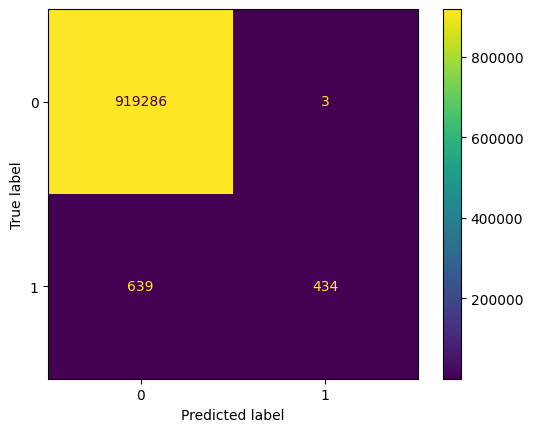

In [76]:
# Plot confusion matrix
cm = confusion_matrix(labels_small, final_preds_small, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot();

## Medium DS Random Forest

In [77]:
%%skip $skip_medium_experiments

# Load the data
hi_medium_train = spark.read.parquet('./data/02_model_input/hi_medium_train.parquet')
hi_medium_test = spark.read.parquet('./data/02_model_input/hi_medium_test.parquet')

# Count the labels to generate the class weights
label_counts_medium = hi_medium_train.groupBy("Is Laundering").count().cache()
zero_class_medium = label_counts_medium.where(col("Is Laundering") == 0).collect()[0]['count']
one_class_medium = label_counts_medium.where(col("Is Laundering") == 1).collect()[0]['count']

# Assign class weights
medium_weights = [1.0, zero_class_medium/one_class_medium]

In [78]:
%%skip $skip_medium_experiments

# Set Parameters for the tree classifier
tree_params_medium = {
    "tree_id": 0,
    "max_depth": 16,
    "threshold": 'bigdata',
    "buckets": 20,
    "min_samples_per_split": 14,
    "disp_mode": "random_forest",
    "func_type": "shannon",
    "weights": medium_weights
}

# Set parameters for the dataset
ds_params_medium = {
    "label": "Is Laundering",
    "col_frac": 0.8,
    "row_frac": 0.20,
}

# Set the amount of trees in the random forest
num_trees_medium = 6

# Fit the model
random_forest_medium = distribute_training(hi_medium_train, ds_params_medium, tree_params_medium, workers=num_trees_medium)

[Worker 0] Preparing Data
[Worker 0] Creating Tree
[Worker 0] F1-Score: 0.6758839528558477
[Worker 0] Recall: 0.5294744318181818
[Worker 0] Precission: 0.9342105263157895
[Worker 0] Accuracy: 0.999403366556359
[Worker 1] Preparing Data
[Worker 1] Creating Tree
[Worker 1] F1-Score: 0.5973365617433414
[Worker 1] Recall: 0.43578872990637696
[Worker 1] Precission: 0.9492112350904194
[Worker 1] Accuracy: 0.9993056871859831
[Worker 2] Preparing Data
[Worker 2] Creating Tree
[Worker 2] F1-Score: 0.6930365799911855
[Worker 2] Recall: 0.5551632833186231
[Worker 2] Precission: 0.9220170038111991
[Worker 2] Accuracy: 0.9994185722547104
[Worker 3] Preparing Data
[Worker 3] Creating Tree
[Worker 3] F1-Score: 0.6152038538362119
[Worker 3] Recall: 0.45729257641921395
[Worker 3] Precission: 0.9396984924623115
[Worker 3] Accuracy: 0.9993162139759599
[Worker 4] Preparing Data
[Worker 4] Creating Tree
[Worker 4] F1-Score: 0.6571428571428571
[Worker 4] Recall: 0.5103909827404015
[Worker 4] Precission: 0.9

In [79]:
%%skip $skip_medium_experiments
# Set prediction parameters
pred_params_medium = {
    "num_batches": 4,
    "label": "Is Laundering",
    "col_frac": 0.8,
}

# Get Test Predictions
final_preds_medium, labels_medium = distribute_predict(random_forest_medium, hi_medium_test, pred_params_medium)

[Cluster Manager] Creating Data Chunks
[Cluster Manager] 4 Chunks Created
[Cluster Manager] Distributing Chunk 0
[Worker 0] Creating Data
[Worker 0] Predicting
[Worker 1] Creating Data
[Worker 1] Predicting
[Worker 2] Creating Data
[Worker 2] Predicting
[Worker 3] Creating Data
[Worker 3] Predicting
[Worker 4] Creating Data
[Worker 4] Predicting
[Worker 5] Creating Data
[Worker 5] Predicting
[Cluster Manager] Distributing Chunk 1
[Worker 0] Creating Data
[Worker 0] Predicting
[Worker 1] Creating Data
[Worker 1] Predicting
[Worker 2] Creating Data
[Worker 2] Predicting
[Worker 3] Creating Data
[Worker 3] Predicting
[Worker 4] Creating Data
[Worker 4] Predicting
[Worker 5] Creating Data
[Worker 5] Predicting
[Cluster Manager] Distributing Chunk 2
[Worker 0] Creating Data
[Worker 0] Predicting
[Worker 1] Creating Data
[Worker 1] Predicting
[Worker 2] Creating Data
[Worker 2] Predicting
[Worker 3] Creating Data
[Worker 3] Predicting
[Worker 4] Creating Data
[Worker 4] Predicting
[Worker 5]

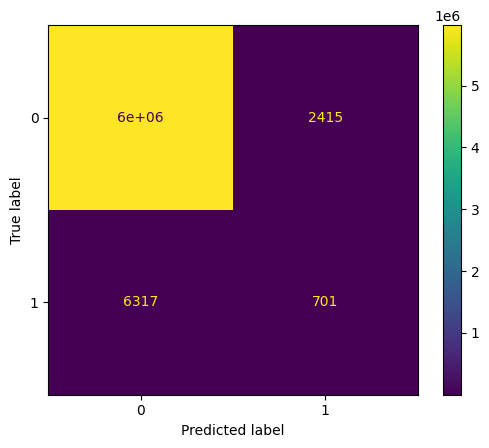

In [80]:
%%skip $skip_medium_experiments
# Plot confusion matrix
cm = confusion_matrix(labels_medium, final_preds_medium, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot();